## svmhard

From A First Course in Machine Learning, Chapter 5.


Simon Rogers, 01/11/21 [simon.d.rogers@gmail.com]

Hard-margin SVM

*Note*: this code requires the package `quadprog`. Can be installed with

```
pip install quadprog
```

*Warning*: the hard margin linear SVM will fail to converge if the data are not linearly separable. The seed setting below should ensure that the random data are linearly separable. Changing the seed offers no such guarantees!

In [161]:
import numpy as np
import pylab as plt
%matplotlib inline

Generate some data

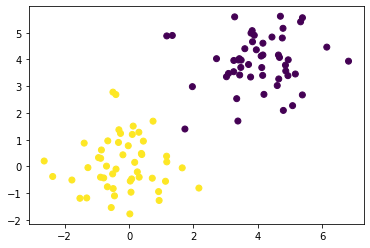

In [209]:
np.random.seed(125)
n = 50
X1 = np.random.multivariate_normal(
    [0, 0],
    np.eye(2),
    size=n
)
X2 = np.random.multivariate_normal(
    [4, 4],
    np.eye(2),
    size=n
)
t1 = np.ones((n, 1), int)
t2 = -1*np.ones((n, 1), int) # note we use +- 1 for SVM

X = np.vstack((X1, X2))
t = np.vstack((t1, t2))

# to really see the hard margin, we flip point 41
# (if not flipped it it the closest yellow point to the purple class)
t[41] = -t[41]


plt.scatter(X[:, 0], X[:, 1], c=t)

Very basic SVM class. Uses quadprog for the quadratic programming.

In [210]:
import quadprog

class LinearKernel(object):
    def compute_gram(self, X1, X2=None):
        if X2 is None:
            return np.dot(X1, X1.T)
        else:
            return np.dot(X1, X2.T)

class LinearSVM(object):
    def __init__(self, X, t, kernel=LinearKernel()):
        self.X = X
        self.t = t
        self.kernel = kernel
        self.K = self.kernel.compute_gram(X)
        self.N, _ = self.X.shape
    
    def train(self):
        a = np.ones(N)
        tt = np.dot(self.t, self.t.T)
        G = (self.K * tt) + 1e-10*np.eye(N) # numerical stability
        C = np.hstack((self.t, np.eye(N)))
        b = np.hstack((np.zeros(1), np.zeros(N)))
        self.alp, f, xu, iterations, lagrangian, iact = quadprog.solve_qp(G, a, C, b, meq=1)
        max_idx = self.alp.argmax()
        self.b = self.t[max_idx] - (self.alp*self.t.flatten()*self.K[max_idx, :]).sum()
        return self
    
    def classify(self, testX):
        '''
        Compute raw classification (real) value
        '''
        testK = self.kernel.compute_gram(self.X, testX)
        temp = (self.alp*self.t.flatten())[:, None]*testK
        temp = temp.sum(axis=0) + self.b
        return temp

    def classify_labels(self, testX):
        '''
        Compute predicted label
        '''
        temp = self.classify(testX)
        temp = 1*(temp > 0)
        temp = 2 * temp - 1
        return temp
    
    def get_svs(self, thresh=1e-5):
        '''
        Get the SVs
        '''
        pos = np.where(self.alp >= thresh)[0]
        return self.X[pos,:]
    
    def __str__(self):
        return 'Linear SVM'

Plot the contour at 0 at the solution. Note that non SV alphas are not exactly zero. Here we threshold at 1e-5.

In [211]:
def plot_contours(X, t, classifier, MIN_X=-2,
                  MAX_X=6, MIN_Y=-2, MAX_Y=5,
                  n_x=50, n_y=60, levels=[0.5]):
    
    xv = np.linspace(MIN_X, MAX_X, n_x)
    yv = np.linspace(MIN_Y, MAX_Y, n_y)
    
    Xg, Yg = np.meshgrid(xv, yv)
    
    gridX = np.hstack((
        Xg.ravel()[:, None],
        Yg.ravel()[:, None]
    ))
    
    preds = classifier.classify(gridX)

    Z = np.reshape(preds, (n_y, n_x))

    fig, ax = plt.subplots(figsize=(10, 10))
    ax.scatter(X[:, 0], X[:, 1], c=t)
    CS = ax.contour(Xg, Yg, Z, levels=levels, colors='k')
    ax.clabel(CS, CS.levels, inline=True, fontsize=10)
    ax.set_title(str(classifier))
    return ax


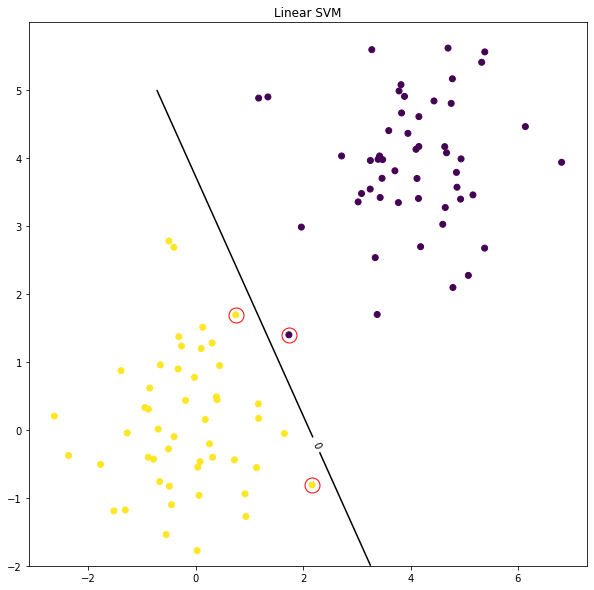

In [212]:
svm = LinearSVM(X, t).train()
ax = plot_contours(X, t, svm, levels=[0.0])
svs = svm.get_svs(thresh=1e-5)
ax.plot(svs[:,0], svs[:, 1], 'ro', markersize=15, markerfacecolor='none')